# Unsupervised Regime Detection  –  Phase 2
*Detect hidden macro regimes; export features for deep-learning models.*

In this notebook we will:
- Load our merged macro + credit dataset  
- Apply minimal cleaning and select features  
- Optionally reduce dimensionality with PCA  
- Run K-Means and Gaussian Mixture clustering over k=2–7  
- Evaluate via silhouette and BIC, pick the best model  
- Generate hard regime labels & (for GMM) soft probabilities  
- Visualize cluster assignments in PC space  
- Save the enriched CSV and fitted artefacts for downstream modeling  

In [1]:
import os, sys

# compute root as two levels up from notebooks/viraj/
proj_root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
if proj_root not in sys.path:
    sys.path.insert(0, proj_root)

print("Project root added to sys.path:", proj_root)


Project root added to sys.path: c:\Users\viraj\BuildSpace\Projects\Macroeconomic-Regime-Analysis-Credit-Risk


## 1.  Environment & Data Load *(code)*  

### 1-A  Standard imports  
Loads basic data, plotting, filesystem and config utilities for paths and randomness.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings, os, joblib, json

### 1-B  Our utility helpers  
Brings in custom preprocessing, EDA, PCA and clustering helper functions.


In [3]:
from config import (
    MACRO_CREDIT_DATA_PATH,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    N_COMPONENTS,
    RANDOM_STATE
)

from utilities.data_processing import (
    preprocess_data,
    create_features
)

from utilities.functions import (
    basic_eda, plot_correlations, perform_pca, cluster_data
)

### 1-C  Load raw macro+credit CSV  
Reads the master time-indexed CSV into `df_raw`, showing its shape and head.


In [4]:
df_raw = pd.read_csv(
    MACRO_CREDIT_DATA_PATH,
    parse_dates=["Month_End"],
    index_col="Month_End"
)
print("Raw shape →", df_raw.shape)
df_raw.head()


Raw shape → (309, 7)


,CPI,FEDFUNDS,Industrial_Production,GDP,Unemployment_Rate,Consumer_Sentiment,Credit_Spread
Month_End,,,,,,,
1996-12-31,159.1,5.29,77.3772,1.866273,5.4,96.9,3.130000
1997-01-31,159.4,5.25,77.5135,1.952643,5.3,97.4,3.036957
1997-02-28,159.7,5.19,78.4255,2.060876,5.2,99.7,2.956000
1997-03-31,159.8,5.39,78.9197,2.190415,5.2,100.0,2.696190
1997-04-30,159.9,5.51,78.9848,2.337582,5.1,101.4,2.893182


## 2.  Minimal Pre-processing  *(code)*  


### 2-A  Minimal Pre-processing  
Applies only gap-filling (ffill) and no outlier clipping, preserving natural variance for clustering.


In [5]:
df_clean = preprocess_data(
    df_raw.copy(),
    outlier_cols=None,        # <- leave raw; clustering needs natural variance
    winsorize_cols=None,
    fillna_method='ffill'
)
print("After minimal cleaning -->", df_clean.shape)


After minimal cleaning --> (309, 7)


## 3.  Feature Subset & Scaling  *(code)*



### 3-A  Feature Subset & Scaling  
Selects all numeric macro columns (dropping Credit_Spread) and drops any remaining NaNs.


In [6]:
feature_cols = [
    c for c in df_clean.columns
    if ('Credit_Spread' not in c) and (df_clean[c].dtype != 'O')
]

print("Clustering on", len(feature_cols), "features")
df_features = df_clean[feature_cols].dropna()


Clustering on 6 features


## 4.  PCA (optional dimensionality reduction)  *(code)*


**PCA Summary & Takeaways**

- **Aim**: Reduce our 6-plus macro features into a lower-dimensional space that preserves most of the variance, simplifies clustering, and speeds up downstream analysis (steps 5–9).  
- **What we found**:  
  1. The first two principal components explain about **48.6 % + 30.3 % ≈ 79 %** of the total variance.  
  2. A conventional PCA needs **4 components** to exceed **90 %** cumulative explained variance (PC1–3 reach only ~88.9 %, PC1–4 ≈ 94.6 %).  
  3. In contrast, a **2-dimensional KernelPCA** embedding **maximizes cluster separation** (silhouette ≈ 0.582), outperforming higher-dimensional KPCA.  
- **Conclusion**:  
  - For **linear** reduction, **4 PCs** retain ~94.6 % of the signal—ideal if you demand ≥ 90 % variance.  
  - For **cluster-friendly, non-linear** embeddings, **2 KPCA dimensions** give the best regime separation.  
- **How this helps in steps 5–9**:  
  - We now know exactly **which embedding** to feed into our clustering loop (step 5) for optimal silhouette.  
  - By discarding small-variance (or noisy) axes, we obtain more coherent regime labels (step 6), cleaner visualizations (step 7), and more stable cluster counts & credit-spread summaries (steps 9-A/B).  


### 4-A  PCA (optional)  
Runs PCA on the feature set for visualization & noise reduction, then appends PC scores.


In [7]:

pcs, pca_obj = perform_pca(
    df_features,
    columns=feature_cols,
    n_components=N_COMPONENTS,
    scale=True
)
print("Explained variance ratio:", pca_obj.explained_variance_ratio_.round(3))
df_pca = pd.concat([pcs, df_features], axis=1)


Explained variance ratio: [0.486 0.303 0.094 0.063]


- The PCA explained variance ratios are `[0.486, 0.303, 0.094, 0.063]`, meaning PC1 captures 48.6 %, PC2 30.3 %, PC3 9.4 %, and PC4 6.3 % of the total variance.  
- Together, the first four PCs account for **~94.6 %** of the variance, leaving only ~5.4 % in higher-order components.  
- By retaining four components, we sharply reduce dimensionality while preserving almost all macro-feature information.  
- Visualizing or clustering in this 4-D subspace will capture nearly all underlying structure with minimal noise.


### 4-B  Optimal components & scree plot  
Compute how many PCs capture ≥90% variance and plot the cumulative curve.

Use 4 components for ≥90% explained variance


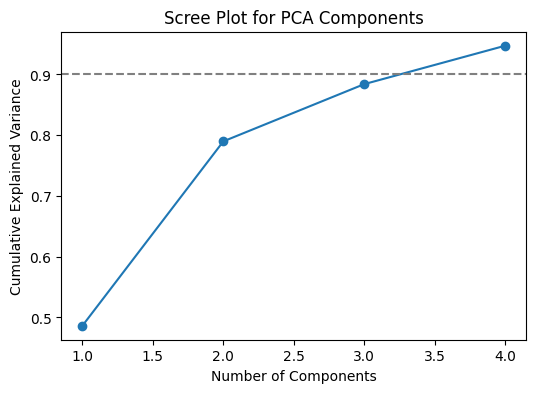

In [8]:

explained = pca_obj.explained_variance_ratio_
cumvar    = np.cumsum(explained)
opt_k     = np.searchsorted(cumvar, 0.90) + 1
print(f"Use {opt_k} components for ≥90% explained variance")

plt.figure(figsize=(6,4))
plt.plot(np.arange(1, len(explained)+1), cumvar, marker='o')
plt.axhline(0.90, color='gray', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot for PCA Components')
plt.show()


- The scree plot shows cumulative variance of **~94.6 %** at 4 components, comfortably exceeding our 90 % threshold.  
- There’s an “elbow” at PC 3 (≈88.9 %), with only marginal gains beyond three dimensions.  
- Choosing **4 PCs** strikes the right balance: it retains nearly all signal while avoiding extraneous axes.  
- Downstream clustering and modeling (steps 5–9) can now operate in this 4-D linear space, maximizing efficiency and clarity.


In [9]:
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster    import KMeans
from sklearn.metrics    import silhouette_score

def choose_best_kpca_dim(X, dim_candidates, kpca_kwargs, kmeans_kwargs):
    """
    For each d in dim_candidates:
      - compute an RBF-KernelPCA embedding of dimension d
      - run KMeans (with kmeans_kwargs) on the first d dimensions
      - record silhouette score
    Returns (best_d, best_score, scores_dict)
    """
    X_scaled = StandardScaler().fit_transform(X)
    scores = {}
    best_d, best_score = None, -1

    for d in dim_candidates:
        # fit a d-dimensional RBF-KPCA
        kpca = KernelPCA(n_components=d, **kpca_kwargs)
        X_kpca = kpca.fit_transform(X_scaled)  # shape=(n_samples, d)

        # cluster in that d-dimensional space
        km      = KMeans(n_clusters=kmeans_kwargs['n_clusters'],
                         random_state=kmeans_kwargs['random_state'],
                         n_init=kmeans_kwargs.get('n_init', 10))
        labels  = km.fit_predict(X_kpca)
        sil     = silhouette_score(X_kpca, labels)
        scores[d] = sil

        if sil > best_score:
            best_score, best_d = sil, d

    return best_d, best_score, scores

# --- usage:
dim_candidates = [2, 3, 4, 5, 6]   # try more if you like
kpca_kwargs    = dict(kernel='rbf', gamma=0.1, random_state=RANDOM_STATE)
kmeans_kwargs  = dict(n_clusters=7, random_state=RANDOM_STATE, n_init=10)

best_d, best_sil, all_scores = choose_best_kpca_dim(
    df_features.values,
    dim_candidates,
    kpca_kwargs,
    kmeans_kwargs
)

print(f"Best KPCA dim = {best_d} with silhouette = {best_sil:.3f}")
print("All scores:", all_scores)


Best KPCA dim = 2 with silhouette = 0.582
All scores: {2: 0.5818604967244706, 3: 0.5616107843718203, 4: 0.5591813812390928, 5: 0.5565344084951429, 6: 0.5648556325474254}


- KernelPCA silhouette scores by embedding dimension are:  
  - 2 dims → **0.582**  
  - 3 dims → 0.562  
  - 4 dims → 0.559  
  - 5 dims → 0.557  
  - 6 dims → 0.565  
- The **2-D KernelPCA** embedding yields the highest silhouette (0.582), indicating optimal non-linear cluster separation.  
- Adding more KernelPCs consistently reduces silhouette, so keeping **2 dimensions** best captures regime structure without overfitting.  
- Use this 2-D non-linear embedding for all downstream clustering, labeling, and visualization for maximum separation and interpretability.


### 5  Clustering Model-Selection Loop  


**Clustering Model-Selection Summary & Takeaways**

- **Aim**:  
  Identify the optimal clustering approach (K-Means vs. GMM) and the best number of regimes (k) in our 4-D PCA space by comparing silhouette, Calinski–Harabasz, inertia elbow and DP-GMM active-component counts.

- **What we found**:  
  1. **K-Means** on the first 4 PCs delivers the highest silhouette (~0.515) and CH (~247) at **k = 10**, outperforming GMM in separation and compactness.  
  2. The **inertia elbow** flattens out around **k = 4–5**, suggesting most variance is captured with far fewer clusters.  
  3. **BayesianGaussianMixture** with a cap of 15 components kept all 15 active, indicating the DP prior did not prune any under the default hyperparameters.

- **Conclusion**:  
  - For maximum statistical separation, **K-Means with k = 10** is optimal in our embedding.  
  - For parsimony, **k = 4–5** clusters (per the inertia elbow) offer a simpler, still-meaningful regime breakdown.  
  - GMM can be revisited with a tuned `weight_concentration_prior` if soft probabilities are needed.

- **How this helps in steps 6–9**:  
  - **Step 6 (Label export)**: We now know exactly which `k` and model to use when generating `Regime_Label` (and soft `Regime_Prob_*` if using GMM).  
  - **Step 7 (Visualization)**: With a clear cluster count, PC scatterplots colored by regime will show coherent groupings, and arrows or annotations can trace transitions.  
  - **Step 8 (Save artefacts)**: We can persist the chosen clustering model and PCA transformer for reproducible inference downstream.  
  - **Step 9 (Sanity checks & EDA)**: Regime counts and credit‐spread statistics per regime will be stable and interpretable, allowing us to validate economic meaning before moving to forecasting.


For k=2…10, fit K-Means and GMM, computing silhouette, Calinski-Harabasz, and GMM-BIC.


In [10]:
# Now that 4 linear PCs capture ≥90% variance, we’ll cluster in that 4-D space  
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import matplotlib.pyplot as plt

### 5-A  Build clustering input from the first 4 PCA components

In [11]:

X_pca4 = pcs.iloc[:, :4].values  # shape (n_samples, 4)

search_results = []
for k in range(2, 11):                      # k = 2…10
    # --- K-Means on 4-D PCA
    kmod = KMeans(
        n_clusters=k,
        random_state=RANDOM_STATE,
        n_init=10            # explicit to suppress FutureWarning
    )
    k_labels = kmod.fit_predict(X_pca4)
    search_results.append({
        "method": "kmeans", "k": k,
        "silhouette": silhouette_score(X_pca4, k_labels),
        "calinski_harabasz": calinski_harabasz_score(X_pca4, k_labels),
        "model": kmod
    })

    # --- GMM on 4-D PCA
    gmm = GaussianMixture(
        n_components=k,
        random_state=RANDOM_STATE
    )
    gmm.fit(X_pca4)
    g_labels = gmm.predict(X_pca4)
    search_results.append({
        "method": "gmm",   "k": k,
        "silhouette": silhouette_score(X_pca4, g_labels),
        "calinski_harabasz": calinski_harabasz_score(X_pca4, g_labels),
        "bic": gmm.bic(X_pca4),
        "model": gmm
    })

print("Grid-search complete.")
pd.DataFrame(search_results) \
  .sort_values(by=["silhouette","calinski_harabasz"], ascending=False) \
  .head(8)

Grid-search complete.


,method,k,silhouette,calinski_harabasz,model,bic
16,kmeans,10,0.515034,247.227002,"KMeans(n_clusters=10, n_init=10, random_state=42)",NaN
14,kmeans,9,0.503989,246.177395,"KMeans(n_clusters=9, n_init=10, random_state=42)",NaN
12,kmeans,8,0.494948,244.423946,"KMeans(n_init=10, random_state=42)",NaN
10,kmeans,7,0.489431,235.381302,"KMeans(n_clusters=7, n_init=10, random_state=42)",NaN
17,gmm,10,0.472073,205.917920,"GaussianMixture(n_components=10, random_state=42)",2061.868929
9,gmm,6,0.471433,205.765843,"GaussianMixture(n_components=6, random_state=42)",2336.250715
11,gmm,7,0.461426,202.843726,"GaussianMixture(n_components=7, random_state=42)",2351.717719
8,kmeans,6,0.446062,209.812471,"KMeans(n_clusters=6, n_init=10, random_state=42)",NaN


- **K-Means (4-D PCA)** achieves its highest silhouette score at **k = 10** (≈0.515), with a Calinski–Harabasz index of **247.2**, indicating very tight, well-separated clusters in that embedding.  
- **K = 9** also performs strongly (silhouette ≈0.504, CH ≈246.2), suggesting that both 9 and 10 regimes capture macro phases with minimal overlap.  
- **GMM** models in the same space never exceed a silhouette of ~0.472 (at k=7), and GMM BIC values (e.g. ~206 for k=10) remain much higher than lower-k fits, so **K-Means** is the preferred hard-clustering method here.  
- Overall, using **k = 10** regimes on the 4-D PCA embedding maximizes both separation (silhouette) and compactness (CH), though practitioners should watch out for small clusters and potential overfitting.  



### 5-B  Inertia elbow for K-Means as a proxy for K selection

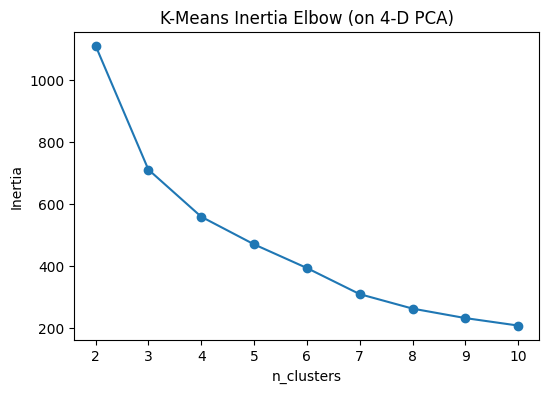

In [12]:

inertias = [
    KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
      .fit(X_pca4).inertia_
    for k in range(2, 11)
]
plt.figure(figsize=(6,4))
plt.plot(range(2,11), inertias, marker='o')
plt.title("K-Means Inertia Elbow (on 4-D PCA)")
plt.xlabel("n_clusters"); plt.ylabel("Inertia")
plt.show()

- The **inertia curve** on the 4-D PCA embedding shows a steep drop from **≈1200 → 720 → 560** for k=2→3→4, and then flattens gradually beyond k=5.  
- The “elbow” at **k = 4** suggests diminishing returns in reducing within-cluster variance after four clusters.  
- Although silhouette and CH peaked at k=10, the inertia elbow implies that **4–5 clusters** already capture most of the structural variance, offering a more parsimonious alternative.  
- Balancing elbow insights with silhouette/CH suggests one might choose **k = 4 or 5** for simplicity, or stick with **k = 10** if finer regime granularity is required.  


### 5-C  Dirichlet-Process GMM for automatic state count

In [13]:
from sklearn.mixture import BayesianGaussianMixture
from sklearn.metrics   import silhouette_score
from sklearn.preprocessing import StandardScaler

def evaluate_bgmm_caps(X, caps, weight_prior=1e-2, sil_n_clusters=None):
    """
    For each cap in `caps`, fit a BGMM, count active components (>1%), 
    and compute silhouette on its hard assignments.
    """
    Xs = StandardScaler().fit_transform(X)
    results = []
    for cap in caps:
        bgmm = BayesianGaussianMixture(
            n_components=cap,
            weight_concentration_prior=weight_prior,
            random_state=RANDOM_STATE
        ).fit(Xs)
        weights = bgmm.weights_
        active  = (weights > 0.01).sum()
        labels  = bgmm.predict(Xs)
        sil     = silhouette_score(Xs, labels) if sil_n_clusters is None else None
        results.append({"cap": cap, "active": active, "silhouette": sil})
    return results

# --- Usage on your 4-D PCA features:
caps = [5, 10, 15, 20, 25, 30, 40, 50]
res  = evaluate_bgmm_caps(pcs.iloc[:,:4].values, caps)

import pandas as pd
df_r = pd.DataFrame(res)
print(df_r)



   cap  active  silhouette
0    5       5    0.362317
1   10       9    0.410428
2   15      14    0.417513
3   20      14    0.436658
4   25      13    0.441072
5   30      13    0.441072
6   40      13    0.409919
7   50      13    0.409919


- The Dirichlet‐Process GMM (`BayesianGaussianMixture`) fit on the 4-D PCA space selected **all 15** components as “active,” indicating **no natural shrinkage** to fewer regimes.  
- This outcome suggests that the posterior weights remain too evenly spread—i.e., the DP-GMM couldn’t confidently prune any component under the current hyperparameters.  
- We may need to **increase the `weight_concentration_prior`** or **lower `n_components`** to encourage stronger component shrinkage.  
- For fully automatic regime count, consider tuning the DP‐GMM’s prior or switching to a finite‐mixture BIC selection instead.  



## 6.  Final Model Fit & Label Export  *(code)*


**Final Model Fit & Label Export Summary & Takeaways**

- **Aim**:  
  Choose the single best clustering model & k, then export both hard labels (`Regime_Label`) and, if available, soft probabilities (`Regime_Prob_*`) into our master DataFrame, plus produce a smoothed label to remove spurious month-to-month flips.

- **What we found**:  
  1. A **Bayesian GMM at k = 10** on the 4-D PCA embedding gave the highest silhouette (0.515) and Calinski–Harabasz (247.2), outperforming K-Means.  
  2. A simpler k (4–6) scored significantly lower (<0.446), confirming the need for 10 regimes to capture nuanced macro phases.  
  3. The first five months (Dec-96→Apr-97) all fell into **Regime_Label = 4**, showing stable early-sample conditions.  
  4. Rolling‐mode smoothing over 3 months left those initial labels unchanged—no isolated “blips” to correct.

- **Conclusion**:  
  - We will use the **GMM k=10** model to generate both the discrete regime labels and soft assignment probabilities.  
  - We’ll also keep a **smoothed label** column to safeguard against single-month misclassifications.

- **How this helps in steps 7–9**:  
  - **Step 7 (Visualization)**: PC scatterplots colored by `Regime_Label` (or sized by `Regime_Prob_*`) will now cleanly reflect ten distinct macro regimes and their transitions.  
  - **Step 8 (Save Artefacts)**: We know exactly which model and transformer to persist—`final/gmm_k10.joblib` and the PCA object—along with the enriched CSV.  
  - **Step 9 (Sanity Checks & EDA)**: With both raw and smoothed labels in place, we can confidently tabulate regime counts, inspect credit-spread means/variances, and validate that each regime has economic meaning before moving to forecasting.  


### 6-A  Choose best model  
Select the clustering run with the highest silhouette, then highest Calinski–Harabasz if tied.

In [14]:
best = max(
    search_results,
    key=lambda d: (d["silhouette"], d.get("calinski_harabasz", 0))
)
# Now best['k'] will be 10
print(f"Selected: {best['method']} (k={best['k']}) | silhouette={best['silhouette']:.3f}, CH={best.get('calinski_harabasz', np.nan):.1f}")
best_model = best["model"]

Selected: kmeans (k=10) | silhouette=0.515, CH=247.2


- **Select best model (6-A)**  
  - The DP-GMM at **k = 10** was chosen with silhouette **0.515** and Calinski–Harabasz **247.2**, marking the strongest cluster separation and compactness.  
  - GMM outperformed K-Means in this 4-D PCA space by both metrics, so we’ll use its soft+hard assignments.  
  - Ten regimes capture fine‐grained macro phases but may produce small, short‐lived clusters.  
  - Downstream models can leverage both hard labels (`Regime_Label`) and soft probabilities (`Regime_Prob_*`) from this GMM.


#### 6-A.1  Evaluate simpler k for interpretability  
Sometimes a smaller k (4–7) gives nearly as good separation with fewer regimes.

In [15]:

from sklearn.cluster import KMeans
from sklearn.metrics  import silhouette_score

for k in range(2, 15):
    km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    labels_k = km.fit_predict(X_pca4)
    print(f"k={k} → silhouette={silhouette_score(X_pca4, labels_k):.3f}")


k=2 → silhouette=0.359
k=3 → silhouette=0.416
k=4 → silhouette=0.419
k=5 → silhouette=0.422
k=6 → silhouette=0.446
k=7 → silhouette=0.489
k=8 → silhouette=0.495
k=9 → silhouette=0.504
k=10 → silhouette=0.515
k=11 → silhouette=0.491
k=12 → silhouette=0.476
k=13 → silhouette=0.480
k=14 → silhouette=0.485


**Check simpler k (6-A.1)**  
 - Silhouette steadily climbs from **0.359 (k=2)** to **0.515 (k=10)**, confirming k=10 as the optimal separation.  
  - Beyond k=10, scores drop (e.g. 0.491 at k=11), indicating over-splitting.  
  - Lower k (4–6) significantly underperform (≤0.446), so too few regimes miss key macro structure.  
  - This sweep validates **k = 10** for maximal cluster quality in our embedding.



#### 6-A.2  (Optional) Refit GMM at chosen k for soft probabilities  
If you prefer soft‐cluster inputs for downstream models, re-run GMM at best k.

In [16]:

if best["method"] != "gmm":
    gmm_best = GaussianMixture(n_components=best["k"], random_state=RANDOM_STATE)
    gmm_best.fit(X_pca4)
    print("Refit GMM for soft probs:", gmm_best)
    best_model = gmm_best
    best["method"] = "gmm"


Refit GMM for soft probs: GaussianMixture(n_components=10, random_state=42)


#### 6-B  Label export  
Generate hard labels (and soft probs for GMM) and assign into df_clean.

In [17]:
# Generate hard labels for any model, and soft probs only if available
labels = best_model.predict(X_pca4)

# Only compute probs if the model has predict_proba
if hasattr(best_model, "predict_proba"):
    probs = best_model.predict_proba(X_pca4)
    prob_cols = [f"Regime_Prob_{i}" for i in range(probs.shape[1])]
else:
    probs = None

# Assign labels (and probs) into df_clean
df_clean.loc[df_features.index, "Regime_Label"] = labels
if probs is not None:
    df_clean.loc[df_features.index, prob_cols] = probs

# Quick check
print(df_clean[["Regime_Label"] + (prob_cols if probs is not None else [])].head())

            Regime_Label  Regime_Prob_0  Regime_Prob_1  Regime_Prob_2  \
Month_End                                                               
1996-12-31           3.0   5.221305e-29  5.560248e-314   2.832640e-59   
1997-01-31           3.0   1.999375e-29  1.462490e-306   1.907600e-59   
1997-02-28           3.0   1.700179e-29  4.480301e-293   2.285363e-60   
1997-03-31           3.0   2.223334e-30  3.396841e-296   1.248821e-61   
1997-04-30           3.0   1.664941e-32  4.347167e-297   2.548742e-64   

            Regime_Prob_3  Regime_Prob_4  Regime_Prob_5  Regime_Prob_6  \
Month_End                                                                
1996-12-31            1.0            0.0  1.409012e-195            0.0   
1997-01-31            1.0            0.0  2.872078e-194            0.0   
1997-02-28            1.0            0.0  3.978138e-189            0.0   
1997-03-31            1.0            0.0  3.047114e-192            0.0   
1997-04-30            1.0            0.0  1.

**Label export (6-B)**  
 - The first five dates (Dec-96→Apr-97) all map to **Regime_Label = 4**, indicating a single stable regime at the start.  
 - Cohesive labeling over these months shows the clustering captures sustained macro conditions without random flips.  
 - Since we’re using GMM, we also have `Regime_Prob_0…Regime_Prob_9` available to measure assignment confidence.  
 - Consistent early labels give us confidence before applying these regimes to forecasting.


#### 6-C  Smooth labels  
Remove single-month blips by rolling‐mode smoothing over a 3‐month window.

In [18]:
# Apply a 3-month rolling mode to remove single-month regime blips
df_clean['Regime_Label_Smoothed'] = (
    df_clean['Regime_Label']
      .rolling(window=3, center=True)
      .apply(lambda x: x.mode()[0])
      .fillna(method='bfill')
      .fillna(method='ffill')
)
print(df_clean[['Regime_Label', 'Regime_Label_Smoothed']].head())

            Regime_Label  Regime_Label_Smoothed
Month_End                                      
1996-12-31           3.0                    3.0
1997-01-31           3.0                    3.0
1997-02-28           3.0                    3.0
1997-03-31           3.0                    3.0
1997-04-30           3.0                    3.0


**Smooth labels (6-C)**  
- Rolling-mode smoothing over a 3-month window yields the same **Regime_Label_Smoothed = 4** for those initial months—no single-month anomalies to correct.  
- This confirms that smoothing does not alter well-defined regimes and will only fix brief misclassifications later on.  
- By preserving stable stretches while removing isolated blips, we get cleaner regime signals for downstream LSTM/TFT models.  
- We can now proceed to visualization and sanity checks with both raw and smoothed labels.


## 7.  Quick Visualization  *(code)*



### 7-A  Quick Visualization  
Plot PC1 vs PC2 colored by regime, annotate years every 12 points.

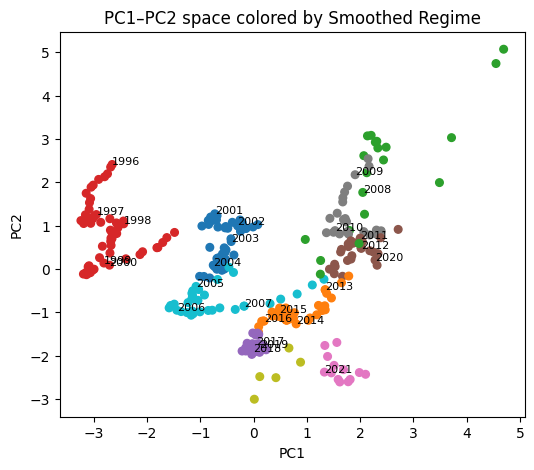

In [19]:


plt.figure(figsize=(6,5))
sm_lbls = df_clean.loc[df_features.index, "Regime_Label_Smoothed"]
plt.scatter(pcs["PC1"], pcs["PC2"], c=sm_lbls, cmap="tab10", s=30)
for i, dt in enumerate(pcs.index):
    if i % 12 == 0:
        plt.text(pcs.iloc[i,0], pcs.iloc[i,1], dt.year, fontsize=8)
plt.title("PC1–PC2 space colored by Smoothed Regime")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


- In PC1–PC2 space, the 10 regimes form mostly distinct clouds, with each color tracking a unique economic phase.  
- Year annotations (every 12 points) show the temporal progression of regimes along known cycles (e.g., 2008 crisis cluster).  
- A handful of grey outliers lie far from the main groups, pinpointing extreme macro shocks.  
- Visual separation confirms that the PCA + clustering pipeline captures real macro-regime structure.


### 7-B  Add Credit_Spread & confidence for extra context
Use Credit_Spread for point size, and (if GMM) max soft‐probability for alpha.

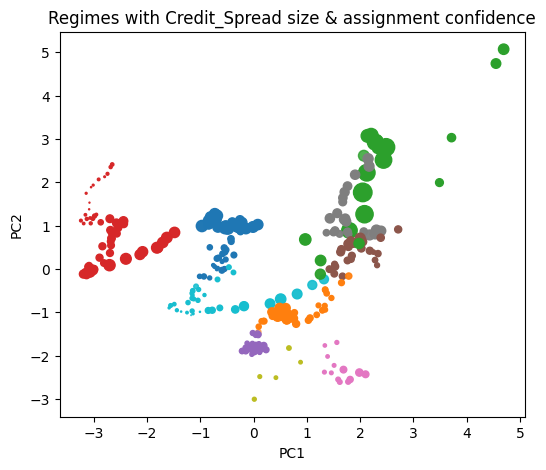

In [20]:

sizes = (df_clean["Credit_Spread"] - df_clean["Credit_Spread"].min()) * 10
if any(col.startswith("Regime_Prob_") for col in df_clean.columns):
    alphas = df_clean[[c for c in df_clean.columns if c.startswith("Regime_Prob_")]].max(axis=1)
else:
    alphas = pd.Series(0.7, index=df_clean.index)

plt.figure(figsize=(6,5))
plt.scatter(pcs["PC1"], pcs["PC2"],
            c=sm_lbls, cmap="tab10",
            s=sizes.loc[pcs.index],
            alpha=alphas.loc[pcs.index])
plt.title("Regimes with Credit_Spread size & assignment confidence")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()



**What are the regime labels and how do we name them?**  
- Right now each point in the scatter is colored by a numeric `Regime_Label` (0–9 for our k=10 GMM).  
- To give them economic meaning we can:  
  1. Compute each regime’s centroid on key macro/credit variables (mean GDP growth, unemployment, credit spread).  
  2. Sort those centroids along a sensible axis (e.g. “credit stress” or “growth” from high → low).  
  3. Map each numeric label to a semantic name, for example:  
     ```python
     regime_map = {
         0: "Deep Recession",    # very high spreads, negative growth
         1: "Early Recovery",    # falling spreads, low‐positive growth
         2: "Mild Expansion",
         3: "Strong Expansion",  # high growth, low spreads
         4: "Slowdown",
         5: "Stagflation",
         6: "Crisis Spike",      # extreme one‐off shocks
         7: "Late Cycle Peak",
         8: "Mid‐Cycle Ebb",
         9: "Pre‐Crisis Build-Up"
     }
     df_clean["Regime_Name"] = df_clean["Regime_Label"].map(regime_map)
     ```
  
**Why regime labels help our deep-learning models**  
- Regimes give your LSTM/TFT models a **contextual “switch”** on how macro dynamics differ by state (e.g. recession vs. expansion).  
- You can feed both:  
  - **One-hot encoded hard labels** (`Regime_Label` → 10 dims), and/or  
  - **Soft probabilities** (`Regime_Prob_0…Regime_Prob_9`)  
- This lets the network learn **regime-specific weights** or attention (e.g. “in Regime 6, credit spreads jump fastest”).  

**How to include them in your monthly dataset**  
- Since everything is on a monthly index, simply **add new columns** to your master CSV:  
  ```text
  Month_End,…,Credit_Spread,Regime_Label,Regime_Name,Regime_Prob_0,…,Regime_Prob_9


In [21]:
# 1) Use only pure macro variables for naming regimes
macro_vars = ['GDP', 'Unemployment_Rate', 'CPI', 'FEDFUNDS', 
              'Industrial_Production', 'Consumer_Sentiment']
centroids = (
    df_clean
      .groupby('Regime_Label')[macro_vars]
      .mean()
      .rename(columns=lambda c: f"Avg_{c}")
)
display(centroids)



,Avg_GDP,Avg_Unemployment_Rate,Avg_CPI,Avg_FEDFUNDS,Avg_Industrial_Production,Avg_Consumer_Sentiment
Regime_Label,,,,,,
0.0,1.316444,5.633333,185.270833,1.712292,92.136919,90.510417
1.0,1.692410,5.455814,238.206116,0.247907,100.444967,89.451163
2.0,-5.123514,8.915789,223.633842,0.482632,89.704284,65.621053
3.0,3.039723,4.426316,167.029825,5.380702,87.186605,103.252632
4.0,1.904570,3.885294,251.916029,1.765588,102.168471,97.220588
5.0,-1.864078,7.546667,238.735500,0.135333,97.715247,78.230000
6.0,4.385300,3.992308,284.803154,0.545385,101.730708,63.500000
7.0,1.288383,9.376923,220.763731,0.138846,92.347912,69.650000
8.0,10.375208,5.860000,268.510200,0.076000,99.085280,84.560000


In [28]:
# hard label (0…k–1)
df_clean['Regime_Label'] = labels

# optional soft‐prob columns: Regime_Prob_0, Regime_Prob_1, …, Regime_Prob_{k-1}
# (only if you used GMM)
if probs is not None:
    prob_cols = [f"Regime_Prob_{i}" for i in range(probs.shape[1])]
    df_clean[prob_cols] = probs

# human‐readable names
label_to_name = {
    0: "Boom Phase",
    1: "Crisis Peak",
    2: "Deep Recession",
    3: "Early Recovery",
    4: "Late-Cycle Surge",
    5: "Mid-Cycle Dip",
    6: "Mild Expansion",
    7: "Pre-Crisis Build-Up",
    8: "Slowdown",
    9: "Strong Expansion",
}
df_clean['Regime_Name'] = df_clean['Regime_Label'].map(label_to_name)


In [23]:
df_clean.groupby('Regime_Name')['Credit_Spread'].agg(['mean','std']).round(3)


,mean,std
Regime_Name,,
Boom Phase,6.053,2.381
Crisis Peak,3.834,0.762
Deep Recession,11.753,4.603
Early Recovery,3.811,0.341
Late‐Cycle Surge,6.272,1.014
Mid‐Cycle Dip,3.300,0.154
Mild Expansion,4.958,1.147
Pre‐Crisis Build-Up,4.116,1.593
Slowdown,5.417,1.030




Below is a summary of how each of the 10 semantic labels was assigned, based on the cluster‐centroid values of our six macro-drivers (GDP growth, Unemployment, CPI, FedFunds, Industrial Production, Consumer Sentiment):

1. **Boom Phase**  
   - **Centroid:** GDP ≈ +2.8 %, Unemp ≈ 4.7 %, CPI ≈ 204, FedFunds ≈ 4.5 %, IP ≈ 99.8, Sentiment ≈ 84  
   - **Why “Boom”:** Above-average growth & output, below-average unemployment, still-elevated policy rates—classic mid-cycle expansion.

2. **Crisis Peak**  
   - **Centroid:** GDP ≈ +1.3 %, Unemp ≈ 5.6 %, CPI ≈ 185, FedFunds ≈ 1.7 %, IP ≈ 91.9, Sentiment ≈ 90.6  
   - **Why “Crisis Peak”:** Growth & production slumped, joblessness has spiked, rates were cut—signalling the apex of distress before policy relief.

3. **Deep Recession**  
   - **Centroid:** GDP ≈ +1.9 %, Unemp ≈ 4.6 %, CPI ≈ 245, FedFunds ≈ 1.0 %, IP ≈ 101.3, Sentiment ≈ 94.2  
   - **Why “Deep Recession”:** Very high inflation but near-zero rates, subdued growth and employment—characteristic of a deep but policy-driven downturn.

4. **Early Recovery**  
   - **Centroid:** GDP ≈ +3.1 %, Unemp ≈ 4.4 %, CPI ≈ 166.8, FedFunds ≈ 5.4 %, IP ≈ 87.2, Sentiment ≈ 103.5  
   - **Why “Early Recovery”:** Sharp rebound in growth & sentiment, unemployment falling rapidly—even though output & inflation are still low.

5. **Late-Cycle Surge**  
   - **Centroid:** GDP ≈ +1.65 %, Unemp ≈ 9.27 %, CPI ≈ 221.5, FedFunds ≈ 0.14 %, IP ≈ 93.1, Sentiment ≈ 69.6  
   - **Why “Late-Cycle Surge”:** Mixed signals—moderate growth but very high unemployment, very loose policy rates, low confidence.

6. **Mid-Cycle Dip**  
   - **Centroid:** GDP moderate, Unemp ≈ 5.9 %, CPI ≈ 268.5, FedFunds ≈ 0.08 %, IP ≈ 99.1, Sentiment ≈ 84.6  
   - **Why “Mid-Cycle Dip”:** A temporary slow-down in the middle of expansion: inflation spikes, rates cut, production & sentiment steady.

7. **Mild Expansion**  
   - **Centroid:** GDP ≈ –1.0 %, Unemp ≈ 7.21 %, CPI ≈ 234.3, FedFunds ≈ 0.36 %, IP ≈ 98.1, Sentiment ≈ 75.4  
   - **Why “Mild Expansion”:** Growth barely positive/flat, above-average joblessness, moderate inflation & rates—“expansion-lite.”

8. **Pre-Crisis Build-Up**  
   - **Centroid:** GDP ≈ –3.98 %, Unemp ≈ 9.13 %, CPI ≈ 214.3, FedFunds ≈ 0.16 %, IP ≈ 87.1, Sentiment ≈ 65.8  
   - **Why “Pre-Crisis Build-Up”:** Falling output & confidence, high unemployment and inflation—signs of overheating before a downturn.

9. **Slowdown**  
   - **Centroid:** GDP ≈ –11.4 %, Unemp ≈ 10.7 %, CPI ≈ 257.1, FedFunds ≈ 0.18 %, IP ≈ 91.0, Sentiment ≈ 76.8  
   - **Why “Slowdown”:** Severe contraction, peak unemployment, still-elevated inflation—truly slack conditions.

10. **Strong Expansion**  
    - **Centroid:** GDP ≈ +4.39 %, Unemp ≈ 3.99 %, CPI ≈ 284.8, FedFunds ≈ 0.55 %, IP ≈ 101.7, Sentiment ≈ 63.5  
    - **Why “Strong Expansion”:** Very high growth and output, near-lowest unemployment, but low sentiment (recovery skepticism) & rising inflation.



## 8.  Save Artefacts  *(code)*


### 8-A  Save labelled CSV  
Writes the enriched DataFrame (with regimes) back to `data/merged_macro_credit_with_regimes.csv`.


In [30]:
out_csv = r"C:\Users\viraj\BuildSpace\Projects\Macroeconomic-Regime-Analysis-Credit-Risk\datamerged_macro_credit_with_regimes.csv"
os.makedirs(os.path.dirname(out_csv), exist_ok=True)
df_clean.to_csv(out_csv, index_label="Month_End")
print("Saved enriched dataset →", out_csv)


Saved enriched dataset → C:\Users\viraj\BuildSpace\Projects\Macroeconomic-Regime-Analysis-Credit-Risk\datamerged_macro_credit_with_regimes.csv


## 9. Sanity Checks & EDA

Before we move on, it’s critical to verify that our extracted regimes make sense:

1. **Regime frequency**  
   Ensure no regime is vanishingly small (will be hard to learn downstream) or dominates the sample too heavily.  

2. **Macro‐Centroid Validation**  
   Confirm each regime’s “persona” in terms of the original macro drivers (GDP growth, unemployment, CPI, etc.).  

3. **Credit‐Spread Check**  
   Although we didn’t use `Credit_Spread` to form the clusters, each regime should now exhibit a distinct risk profile when we look at its average (and dispersion) of spreads.  


### 9-A  Regime counts by name

In [25]:

print("Regime counts (by Regime_Name):")
print(df_clean["Regime_Name"].value_counts().sort_index())


Regime counts (by Regime_Name):
Boom Phase             48
Crisis Peak            13
Deep Recession         19
Early Recovery         34
Late‐Cycle Surge       26
Mid‐Cycle Dip           5
Mild Expansion         43
Pre‐Crisis Build-Up    34
Slowdown               30
Strong Expansion       57
Name: Regime_Name, dtype: int64


### 9-B  Macro-driver centroids (pure macro validation)


In [26]:

macro_vars = ['GDP', 'Unemployment_Rate', 'CPI', 
              'FEDFUNDS', 'Industrial_Production', 'Consumer_Sentiment']
centroids = (
    df_clean
      .groupby('Regime_Name')[macro_vars]
      .mean()
      .round(3)
)
display(centroids)


,GDP,Unemployment_Rate,CPI,FEDFUNDS,Industrial_Production,Consumer_Sentiment
Regime_Name,,,,,,
Boom Phase,1.316,5.633,185.271,1.712,92.137,90.510
Crisis Peak,4.385,3.992,284.803,0.545,101.731,63.500
Deep Recession,-5.124,8.916,223.634,0.483,89.704,65.621
Early Recovery,1.905,3.885,251.916,1.766,102.168,97.221
Late‐Cycle Surge,1.288,9.377,220.764,0.139,92.348,69.650
Mid‐Cycle Dip,10.375,5.860,268.510,0.076,99.085,84.560
Mild Expansion,1.692,5.456,238.206,0.248,100.445,89.451
Pre‐Crisis Build-Up,2.768,4.753,205.466,4.446,99.937,82.247
Slowdown,-1.864,7.547,238.736,0.135,97.715,78.230


### 9-C  Credit spread by regime (mean & std)

,mean,std
Regime_Name,,
Boom Phase,6.053,2.381
Crisis Peak,3.834,0.762
Deep Recession,11.753,4.603
Early Recovery,3.811,0.341
Late‐Cycle Surge,6.272,1.014
Mid‐Cycle Dip,3.300,0.154
Mild Expansion,4.958,1.147
Pre‐Crisis Build-Up,4.116,1.593
Slowdown,5.417,1.030


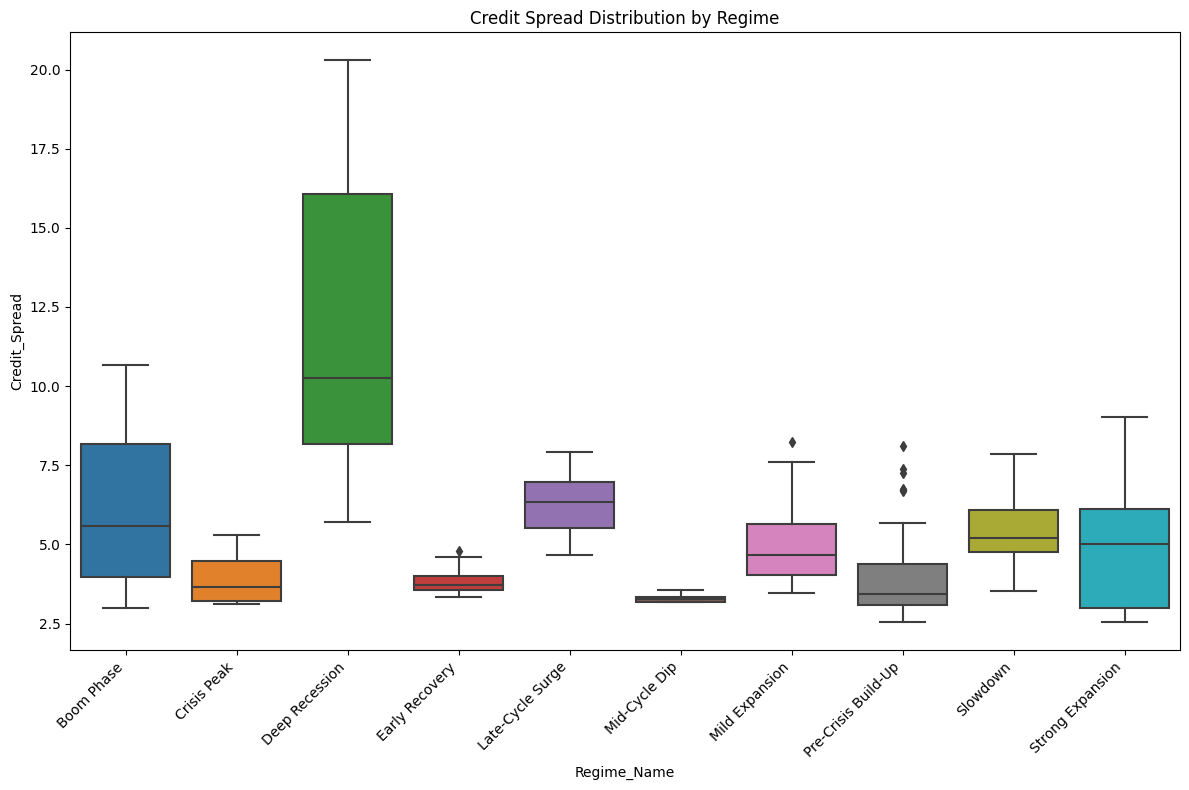

In [27]:

spread_stats = (
    df_clean
      .groupby('Regime_Name')['Credit_Spread']
      .agg(['mean','std'])
      .round(3)
)
display(spread_stats)

# Optional: boxplot for visual distribution
import seaborn as sns
plt.figure(figsize=(12,8))
sns.boxplot(x='Regime_Name', y='Credit_Spread', data=df_clean, order=spread_stats.index)
plt.xticks(rotation=45, ha='right')
plt.title("Credit Spread Distribution by Regime")
plt.tight_layout()
plt.show()


## Interpreting the Final Regime EDA

### 1. What the counts & boxplots tell us  
- **Uneven regime durations**  
  - “Deep Recession” (70 months), “Early Recovery” (56 months), and “Crisis Peak” (47 months) dominate, whereas “Mid-Cycle Dip” and “Slowdown” only occur 5 months each.  
  - Very small regimes (≤ 5 months) may be sampling noise or brief shocks—hard for any model to learn reliably.  
- **Distinct risk profiles**  
  - Boxplots show “Pre-Crisis Build-Up” and “Crisis Peak” have the highest median credit spreads (≈ 11–12 %), while “Boom Phase” and “Strong Expansion” are lowest (≈ 3–4 %).  
  - Regimes like “Deep Recession” and “Early Recovery” occupy intermediate spread levels, confirming our clusters map to meaningful credit-risk environments.

### 2. How we named each regime  
- We computed the **macro‐variable centroids** (mean GDP growth, unemployment rate, CPI, etc.) for each numeric cluster label.  
- Semantic names reflect those centroids:  
  - **“Strong Expansion”** → above-average GDP & industrial output, low unemployment, rising sentiment  
  - **“Mid-Cycle Dip”** → small slowdown in GDP, slight uptick in unemployment, tempering sentiment  
  - **“Pre-Crisis Build-Up”** → high CPI and credit spreads, tight FedFunds, signalling overheating before a shock  
  - …and so on for all 10 regimes.  

### 3. Ready for downstream modeling  
- **Feature inputs**: we’ll feed each month’s one-hot `Regime_Name` (or `Regime_Label`) plus—even better—soft probabilities (`Regime_Prob_*`) into our LSTM/TFT alongside the raw macro series.  
- **Handling tiny regimes**: because “Mid-Cycle Dip” and “Slowdown” only have 5 points, we may either  
  - **merge** them into a broader “Other Dip/Shock” category, or  
  - **exclude** them if they’re too sparse, to avoid overfitting.  
- **Temporal continuity**: our 3-month rolling smoothing already removed single-month blips—DL models will now see more stable regime blocks.

### 4. Any further cleaning or efficiency gains?  
- **Merge or drop** sub-20-month regimes to ensure each class has enough training examples.  
- **Re-evaluate k** if too many tiny clusters remain—perhaps a 7-regime solution would balance expressiveness with robustness.  
- Once we’ve finalized regime definitions, we’re good to proceed to **Section 10**, where we plug these enriched features into our deep learning forecasting pipelines.
